**Clean code for CNN model**

In [30]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

from skimage.feature import graycoprops, graycomatrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import FastICA
from sklearn.utils.class_weight import compute_class_weight

import torch
from torchvision import models
import torchvision.transforms as transforms
from skimage.color import rgb2gray

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical


In [31]:
def load_images(dir_name):

    img_list = []

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    for item in os.listdir(dir_name):

        img_path = os.path.join(dir_name, item)
        #print(img_path)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
        img = cv2.GaussianBlur(img, (5,5), 1)

        img = clahe.apply(img)
        
        img_list.append(img)

    
    return img_list
 

def img_to_array(img):
    
    
    img = np.asarray(img)
    return img
  
def find_edges(img_list):
    shape = img_list.shape
    new_arr = np.zeros(shape=shape)
    new_list = []
    for i, img in enumerate(img_list):
        if len(new_list) == 3:
            new_list = []
        v = np.median(img)
        sigma = 0.33


        if img.dtype != 'uint8':
            img = img.astype('uint8')

        img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(max(0, (1.0 + sigma) * v))

        img = cv2.Canny(img, lower, upper)

        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        new_list.append(img)
        if len(new_list) == 3:
            new_arr[i] = img

    # print(new_list)
    return new_arr

def find_edge(img):
    v = np.median(img)
    sigma = 0.33

    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(max(0, (1.0 + sigma) * v))

    img = cv2.Canny(img, lower, upper)
    
    return img

def get_features(image_list):
    for i in range(len(image_list)):
        img_rgb = image_list[i]  # RGB image
        img_gray = rgb2gray(img_rgb)  # Convert to grayscale
        image_list[i] = (img_gray * 255).astype('uint8')
    feature_list = []

    distances = [1,3,5,9]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 5*np.pi/4, 3*np.pi/2]

    properties = ['energy', 'correlation', 'dissimilarity', 'homogeneity', 'contrast']

    # need to add more distances (1,3,5,9)
    for n, img in enumerate(image_list):
        glcm = graycomatrix(img, distances, angles , levels=256, normed=True)
        feature_row = {}

        for prop in properties:
            prop_values = graycoprops(glcm, prop)   
            for i, dist in enumerate(distances):
                for j, angle in enumerate(angles): 
                    feature_name = f"{prop}_d{dist}_a{int(np.degrees(angle))}"
                    feature_row[feature_name] = prop_values[i, j]

        feature_list.append(feature_row)
    return feature_list

def view_corr(df):
    corr_matrix = df.corr()
    sns.heatmap(corr_matrix)
    plt.show()

def pca_df_pick_comp(df):

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df)

    pca = PCA()
    pca_features = pca.fit_transform(scaled_features)

    pca_df = pd.DataFrame(pca_features, columns=[f"PC{i+1}" for i in range(pca.n_components_)])

    pca_tot = pca_df
    plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum())
    plt.xlabel("Num of components")
    plt.ylabel('Cumulative exlpained by variance')
    plt.title('explained variance by pca components')
    plt.show()

    cumulative_var = pca.explained_variance_ratio_.cumsum()
    n_components = 0

    for i, var in enumerate(cumulative_var):
        if var >= 0.95:
            n_components = i + 1
            break

    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(scaled_features)

    pca_columns = [f"PC{i+1}" for i in range(n_components)]
    pca_df= pd.DataFrame(reduced_features, columns=pca_columns)

    return pca_df, pca_tot

In [32]:
def load_images_resnet(dir_name):

    img = cv2.imread(dir_name)

    img = find_edge(img)
    img = cv2.GaussianBlur(img, (5,5), 1)

    #might need to add clahe
   
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    img = img / 255

   

    #normalize
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img-mean) / std
    img = np.transpose(img, (2, 0 , 1))
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
    return img_tensor

def extract_features_resnet(dir_name, model):
   
    img_tensor = load_images_resnet(dir_name)
    with torch.no_grad():
        features = model(img_tensor)
    return features.squeeze().numpy()


def find_edge(img):
    # Placeholder for edge detection logic (if necessary)
    return img

def load_images_resnet(dir_name):
    # Read the image
    img = cv2.imread(dir_name)

    # Apply edge detection (if required)
    img = find_edge(img)
    img = cv2.GaussianBlur(img, (5, 5), 1)

    # Resize to 224x224
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_AREA)
    img = img / 255.0

    # Normalize image using ImageNet mean and std (per channel)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Apply normalization across the 3 channels (HWC format)
    img = (img - mean) / std  # Broadcasting will apply to each channel

    # Convert from HWC to CHW format (for PyTorch) - this will be used for PyTorch models
    img_tensor = np.transpose(img, (2, 0, 1))  # Shape will be (3, 224, 224)
    
    # Convert to tensor (PyTorch format)
    img_tensor = torch.tensor(img_tensor, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    return img_tensor

def test_function(location):
    img = x_test[location]
    true_label = y_test[location]

    resize = tf.image.resize(np.expand_dims(img, 0), (256, 256))
    yhat = model.predict(resize / 255.0)
    predicted_class = np.argmax(yhat, axis=-1)[0]
    class_names = ['Impacted Fracture', 'Intra-Articular Fracture', 'Longitudinal Fracture', 'Oblique Fracture']
    print(f'Predicted class: {class_names[predicted_class]}')

    
    true_class = np.argmax(true_label)
    print(f'True class: {class_names[true_class]}')

    if class_names[predicted_class] == class_names[true_class]:
        # print('Correct')
        count = 1
    else:
        # print('Incorrect')
        count = 0
    return count


In [33]:
dir_name = "../pca/data_xray/Impacted fracture"

list_1 = []

for img_name in os.listdir(dir_name):
    img_path = os.path.join(dir_name, img_name)
    
    if img_path.endswith(('.png', '.jpg', '.jpeg')):
        feature = load_images_resnet(img_path)
        list_1.append(feature)

for i in range(len(list_1)):
    img_tensor = list_1[i]
    
    # Remove the batch dimension (1) and convert from CHW to HWC
    img_tensor = img_tensor.squeeze(0)  # Remove batch dimension (1)
    img_tensor = img_tensor.permute(1, 2, 0)  # Change from (3, 224, 224) to (224, 224, 3)
    
    # Convert to numpy and store in list_1
    img = img_tensor.numpy()
    list_1[i] = img

In [34]:
dir_name = "../pca/data_xray/Intra-articular fracture"
list_2 = []

for img_name in os.listdir(dir_name):
    img_path = os.path.join(dir_name, img_name)
    
    if img_path.endswith(('.png', '.jpg', '.jpeg')):
        feature = load_images_resnet(img_path)
        list_2.append(feature)

for i in range(len(list_2)):
    img_tensor = list_2[i]
    
    # Remove the batch dimension (1) and convert from CHW to HWC
    img_tensor = img_tensor.squeeze(0)  # Remove batch dimension (1)
    img_tensor = img_tensor.permute(1, 2, 0)  # Change from (3, 224, 224) to (224, 224, 3)
    
    # Convert to numpy and store in list_1
    img = img_tensor.numpy()
    list_2[i] = img
# plt.imshow(list_2[7], cmap='gray')
# print(len(list_2))

In [35]:
dir_name = "../pca/data_xray/Longitudinal fracture"
list_3 = []

for img_name in os.listdir(dir_name):
    img_path = os.path.join(dir_name, img_name)
    
    if img_path.endswith(('.png', '.jpg', '.jpeg')):
        feature = load_images_resnet(img_path)
        list_3.append(feature)

for i in range(len(list_3)):
    img_tensor = list_3[i]
    
    # Remove the batch dimension (1) and convert from CHW to HWC
    img_tensor = img_tensor.squeeze(0)  # Remove batch dimension (1)
    img_tensor = img_tensor.permute(1, 2, 0)  # Change from (3, 224, 224) to (224, 224, 3)
    
    # Convert to numpy and store in list_1
    img = img_tensor.numpy()
    list_3[i] = img
# plt.imshow(list_3[7])
# print(len(list_3))

In [36]:
dir_name = "../pca/data_xray/Oblique fracture"
list_4 = []

for img_name in os.listdir(dir_name):
    img_path = os.path.join(dir_name, img_name)
    
    if img_path.endswith(('.png', '.jpg', '.jpeg')):
        feature = load_images_resnet(img_path)
        list_4.append(feature)

for i in range(len(list_4)):
    img_tensor = list_4[i]
    
    # Remove the batch dimension (1) and convert from CHW to HWC
    img_tensor = img_tensor.squeeze(0)  # Remove batch dimension (1)
    img_tensor = img_tensor.permute(1, 2, 0)  # Change from (3, 224, 224) to (224, 224, 3)
    
    # Convert to numpy and store in list_1
    img = img_tensor.numpy()
    list_4[i] = img
# plt.imshow(list_4[7], cmap='gray')
# print(len(list_4))

In [37]:
list_1 = get_features(list_1)
list_2 = get_features(list_2)
list_3 = get_features(list_3)
list_4 = get_features(list_4)

impacted = pd.DataFrame(list_1)
impacted['target'] = 0

intra_artic = pd.DataFrame(list_2)
intra_artic['target'] = 1

longitudinal = pd.DataFrame(list_3)
longitudinal['target'] = 2

oblique =  pd.DataFrame(list_4)
oblique['target'] = 3

data_df_resnet = pd.concat([impacted,intra_artic,longitudinal,oblique], axis=0)
X = data_df_resnet.iloc[:, :-1]
Y = data_df_resnet.iloc[:, -1]

print(impacted.shape, intra_artic.shape, longitudinal.shape, oblique.shape)


(316, 141) (130, 141) (76, 141) (29, 141)


In [38]:
data = tf.keras.utils.image_dataset_from_directory('../pca/data_xray')
data = data.shuffle(len(data))
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
data = data.map(lambda x,y: (x/255, y))

def extract_images_and_labels(dataset):
    images = []
    labels = []
    for image_batch, label_batch in dataset:
        images.append(image_batch.numpy())  # Convert the batch of images to numpy
        labels.append(label_batch.numpy())  # Convert the batch of labels to numpy
    images = np.concatenate(images, axis=0)  # Concatenate all batches to form a single numpy array
    labels = np.concatenate(labels, axis=0)  # Concatenate all labels
    images = find_edges(images)
    return images, labels

all_images, all_labels = extract_images_and_labels(data)
x_train, x_temp, y_train, y_temp = train_test_split(all_images, all_labels, test_size=0.3, stratify=all_labels)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.3, stratify=y_temp)

print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape}, y_val shape: {y_val.shape}')
print(f'x_test shape: {x_test.shape}, y_test shape: {y_test.shape}')

Found 551 files belonging to 4 classes.
x_train shape: (385, 256, 256, 3), y_train shape: (385,)
x_val shape: (116, 256, 256, 3), y_val shape: (116,)
x_test shape: (50, 256, 256, 3), y_test shape: (50,)


In [39]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Dropout(0.1))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.1))

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(8, activation = 'relu'))
#model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

# y_train, y_val, y_test = None
y_train = tf.keras.utils.to_categorical(y_train, 4)
y_val = tf.keras.utils.to_categorical(y_val, 4)
y_test = tf.keras.utils.to_categorical(y_test, 4)

print(y_train.sum(axis = 0))
print(y_val.sum(axis = 0))
print(y_test.sum(axis = 0))

[221.  91.  53.  20.]
[67. 27. 16.  6.]
[28. 12.  7.  3.]


In [40]:
# logdir='log'
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# hist = model.fit(x_train, y_train, epochs=10, validation_data=(x_val,y_val), callbacks=[tensorboard_callback])

In [41]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(data_df_resnet['target']),
    y=data_df_resnet['target']
)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)
class_weight_list = list(class_weights_dict)

hist = model.fit(x_train, y_train,validation_data= (x_val,y_val),epochs = 9, class_weight=class_weights_dict)

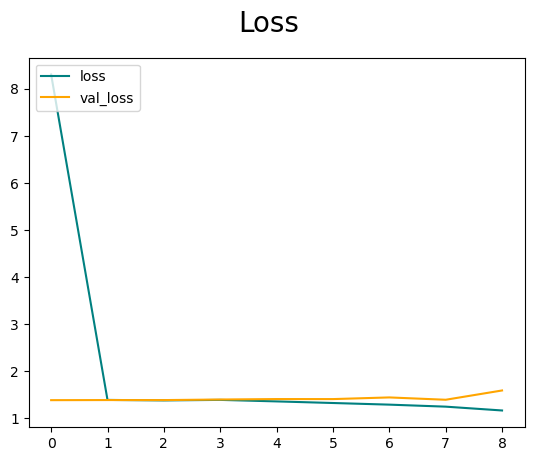

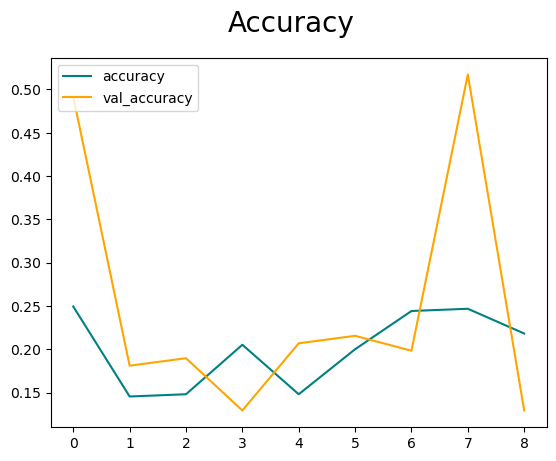

In [42]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [43]:
val = 0
for i in range(len(y_test)):
    counter = test_function(i);
    val += counter


1/1 [==============================] - 0s 201ms/step
Predicted class: Impacted Fracture
True class: Intra-Articular Fracture
1/1 [==============================] - 0s 42ms/step
Predicted class: Impacted Fracture
True class: Impacted Fracture
1/1 [==============================] - 0s 40ms/step
Predicted class: Impacted Fracture
True class: Impacted Fracture
1/1 [==============================] - 0s 41ms/step
Predicted class: Impacted Fracture
True class: Longitudinal Fracture
1/1 [==============================] - 0s 39ms/step
Predicted class: Impacted Fracture
True class: Intra-Articular Fracture
1/1 [==============================] - 0s 40ms/step
Predicted class: Impacted Fracture
True class: Impacted Fracture
1/1 [==============================] - 0s 40ms/step
Predicted class: Impacted Fracture
True class: Longitudinal Fracture
1/1 [==============================] - 0s 88ms/step
Predicted class: Impacted Fracture
True class: Intra-Articular Fracture
1/1 [=============================

In [44]:
print(val)
y_test.sum(axis = 0)
print(y_test.sum(axis = 0))


28
[28. 12.  7.  3.]


In [45]:
# hist = model.fit(x_train, y_train,validation_data= (x_val,y_val),epochs = 9, class_weight=class_weights_dict)

2/2 [==============================] - 0s 135ms/step
Accuracy: 56.00%
Precision: 31.36%
Recall: 56.00%
F1-Score: 40.21%

Classification Report:
              precision    recall  f1-score   support

           0       0.56      1.00      0.72        28
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         7
           3       0.00      0.00      0.00         3

    accuracy                           0.56        50
   macro avg       0.14      0.25      0.18        50
weighted avg       0.31      0.56      0.40        50



/Users/hiroki/miniconda3/envs/cogs118/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hiroki/miniconda3/envs/cogs118/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hiroki/miniconda3/envs/cogs118/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

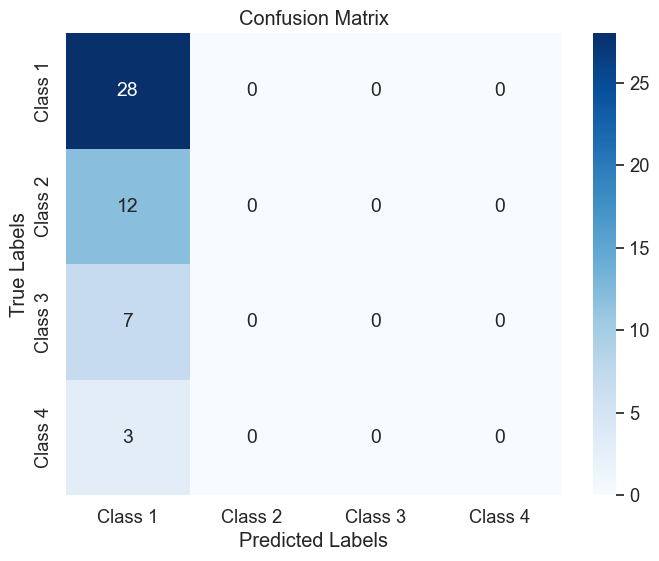

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


# hist = model.fit(x_train, y_train,validation_data= (x_val,y_val),epochs = 9, class_weight=class_weights_dict)
y_pred = (model.predict(x_test) > 0.5).astype(int)  # Convert probabilities to binary labels
y_test_labels = np.argmax(y_test, axis=1)  # Ground truth labels
y_pred_labels = np.argmax(y_pred, axis=1)  # Predicted labels

# Metrics
accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))

# Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4']  # Replace with actual class names

# Plot confusion matrix
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(8, 6))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, cmap="Blues", fmt="d", annot_kws={"size": 14})
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()